# Aggregate hourly gridded data tom daily/monthly/annual means {-}


| Var               | daily | monthly | annual |
|-------------------|-------|---------|--------|
| Wind speed        |   x   |         |        |
| Relative humidity |       |         |        |  
| CAMS PM10         |       |         |        | 
| CAMS PM2.5        |       |         |        | 
| CAMS O3           |       |         |        | 
| CAMS NO2          |       |         |        |  
| ----------------- | ----- | ------- | ------ |  
| Temperature       |       |         |        |  
| Wind direction    |       |         |        |  
| Solar radiation   |       |         |        |  



Specify variable and temporal resolution

- t = "D" for daily
- t = "M" for monthly
- t = "Y" for annual

In [1]:
var = "Wind_Speed"
t = "D"

In [2]:
import datetime
import gc
import glob
import os.path

import numpy as np
import pandas as pd
import xarray as xr
from dask.distributed import Client, LocalCluster, progress
from dask.diagnostics import ProgressBar

client = Client()

In [8]:
outdirs = {"D": "01_daily", "M": "02_monthly", "Y": "03_annual"}
outtimes = {"D": "daily", "M": "monthly", "Y": "annual"}
out = f"../supplementary/{outdirs[t]}/{var}_{outtimes[t]}_2015-2022.nc"
print(out)
files = glob.glob(f"../supplementary/era5/*{var}*")
files.sort()

../supplementary/01_daily/no2_daily_2015-2022.nc


In [16]:
files[44]

'../supplementary/cams/cams.eaq.vra.ENSa.no2.l0.2016-09.nc'

In [17]:
xr.open_dataset(files[43])

<xarray.Dataset>
Dimensions:  (time: 744, lon: 701, lat: 401)
Coordinates:
  * time     (time) datetime64[ns] 2016-08-01 ... 2016-08-31T23:00:00
  * lon      (lon) float64 -25.0 -24.9 -24.8 -24.7 -24.6 ... 44.7 44.8 44.9 45.0
  * lat      (lat) float64 30.0 30.1 30.2 30.3 30.4 ... 69.6 69.7 69.8 69.9 70.0
Data variables:
    no2      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service

In [18]:
xr.open_dataset(files[13])

<xarray.Dataset>
Dimensions:  (time: 672, lon: 700, lat: 420)
Coordinates:
  * time     (time) datetime64[ns] 2022-02-01 ... 2022-02-28T23:00:00
  * lon      (lon) float64 -24.95 -24.85 -24.75 -24.65 ... 44.75 44.85 44.95
  * lat      (lat) float64 30.05 30.15 30.25 30.35 ... 71.65 71.75 71.85 71.95
Data variables:
    no2      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service

In [19]:
xr.open_dataset(files[1])

<xarray.Dataset>
Dimensions:  (time: 672, lon: 701, lat: 421)
Coordinates:
  * time     (time) datetime64[ns] 2021-02-01 ... 2021-02-28T23:00:00
  * lon      (lon) float64 -25.0 -24.9 -24.8 -24.7 -24.6 ... 44.7 44.8 44.9 45.0
  * lat      (lat) float64 30.0 30.1 30.2 30.3 30.4 ... 71.6 71.7 71.8 71.9 72.0
Data variables:
    no2      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service

In [13]:
#data = xr.open_mfdataset(files).isel(latitude=slice(200,220), longitude=slice(300,320)) 
#data = xr.open_mfdataset(files, chunks={"latitude": 154, "longitude": 166})
data = xr.open_mfdataset(files[0:24], chunks={"time": 24*5, "lon": 701, "lat": 421})#, parallel=True)
data = data.rename_dims({"lon": "longitude", "lat": "latitude"})
data

/home/j/jheisig/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1452: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home/j/jheisig/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1452: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slic

ValueError: Resulting object does not have monotonic global indexes along dimension lat

In [39]:
%%time

agg = data.resample(time=t).mean(skipna=True).to_netcdf(out, mode="w", compute=False)
agg_res = agg.persist()
progress(agg_res)

CPU times: user 207 ms, sys: 25.9 ms, total: 233 ms
Wall time: 225 ms


VBox()

In [6]:
gc.collect()

0

In [7]:
r = xr.open_dataset(out)
r

<xarray.Dataset>
Dimensions:    (time: 2922, latitude: 460, longitude: 663)
Coordinates:
  * longitude  (longitude) float32 -30.63 -30.53 -30.43 ... 35.37 35.47 35.57
  * latitude   (latitude) float32 71.66 71.56 71.46 71.36 ... 25.96 25.86 25.76
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2022-12-31
Data variables:
    rh         (time, latitude, longitude) float32 ...

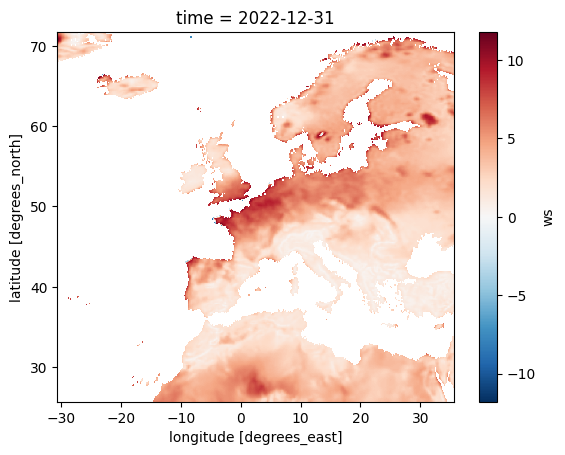

In [7]:
r.ws.isel(time = 2921).plot()

In [ ]:
agg.ws.isel(time = 700).plot()

In [49]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46695,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: 1 hour ago,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:38299,Total threads: 4
Dashboard: http://127.0.0.1:43619/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:40511,
